In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings

In [2]:
train = pd.read_csv('train_log.csv')
test = pd.read_csv('test_log.csv')

In [3]:
new_train = train
new_test = test

In [4]:
new_train.drop(columns=['enroll_id', 'object'], inplace=True)
new_test.drop(columns=['enroll_id', 'object'], inplace=True)

In [5]:
# Substitute various actions with category-type actions
video_action = ['seek_video','play_video','pause_video','stop_video','load_video']
problem_action = ['problem_get','problem_check','problem_save','reset_problem','problem_check_correct', 'problem_check_incorrect']
forum_action = ['create_thread','create_comment','delete_thread','delete_comment']
click_action = ['click_info','click_courseware','click_about','click_forum','click_progress']
close_action = ['close_courseware']

video = ['video']*len(video_action)
problem = ['problem']*len(problem_action)
forum = ['forum']*len(forum_action)
click = ['click']*len(click_action)
close = ['close']*len(close_action)

video_dict = dict(zip(video_action, video))
problem_dict = dict(zip(problem_action, problem))
forum_dict = dict(zip(forum_action, forum))
click_dict = dict(zip(click_action, click))
close_dict = dict(zip(close_action, close))

new_train['action'].replace(video_dict, inplace=True)
new_train['action'].replace(problem_dict, inplace=True)
new_train['action'].replace(forum_dict, inplace=True)
new_train['action'].replace(click_dict, inplace=True)
new_train['action'].replace(close_dict, inplace=True)

new_test['action'].replace(video_dict, inplace=True)
new_test['action'].replace(problem_dict, inplace=True)
new_test['action'].replace(forum_dict, inplace=True)
new_test['action'].replace(click_dict, inplace=True)
new_test['action'].replace(close_dict, inplace=True)


### Retrieve time spent on courses from join with course_info dataframe

In [6]:
courseinfo = pd.read_csv('course_info.csv', index_col='id')

In [7]:
new_train = new_train.merge(courseinfo, on='course_id')
new_test = new_test.merge(courseinfo, on='course_id')

In [8]:
data = pd.concat([new_train, new_test], ignore_index=True)

In [9]:
data.drop(columns=['session_id', 'action', 'start', 'end', 'course_type', 'category'], inplace=True)

In [10]:
data.rename(columns={'time': 'date'}, inplace=True)
data['date'] = pd.to_datetime(data['date'])

In [11]:
data['date'] = data['date'].dt.date

In [12]:
data['count'] = len(data)*[1]

In [13]:
data = data.groupby(by=['username', 'course_id', 'date']).count().reset_index()

In [14]:
data

,username,course_id,date,count
0,5,TsinghuaX/60510102X/_,2015-10-12,11
1,5,TsinghuaX/70240183x/2015_T2,2015-09-30,43
2,5,TsinghuaX/80511503X/2015_T2,2015-11-10,8
3,5,TsinghuaX/80511503X/2015_T2,2015-11-13,50
4,5,TsinghuaX/80511503X/2015_T2,2015-11-16,1
...,...,...,...,...
673155,7011178,course-v1:TsinghuaX+AP000008X+2017T1,2017-05-05,46
673156,7019483,course-v1:TsinghuaX+20320074X+2017_T1,2017-05-11,40
673157,7023562,course-v1:TsinghuaX+AP000008X+2017T1,2017-05-12,267
673158,7036067,course-v1:TsinghuaX+AP000008X+2017T1,2017-05-15,20


In [15]:
temp = data.pivot(index=['username', 'course_id'], columns='date').fillna(0).reset_index()

In [16]:
temp.columns = temp.columns.droplevel()

In [17]:
cols = list(temp.columns)
cols[0] = 'username'
cols[1] = 'course_id'
temp.columns = cols

In [18]:
temp.drop(columns=['username', 'course_id'], inplace=True)

## Build Prophet model for platform traffic prediction

In [19]:
df_prophet_pivot = temp.T.reset_index()

In [20]:
df_prophet_pivot.rename(columns={'index':'ds'}, inplace=True)

In [21]:
df_prophet_pivot['y'] = df_prophet_pivot[list(df_prophet_pivot.columns)[1:]].sum(axis=1)

In [22]:
df_prophet_pivot

,ds,0,1,2,3,4,5,6,7,8,...,225633,225634,225635,225636,225637,225638,225639,225640,225641,y
0,2015-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5275.0
1,2015-06-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11399.0
2,2015-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13734.0
3,2015-06-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13044.0
4,2015-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12876.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,2017-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2072.0
609,2017-06-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,739.0
610,2017-06-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1239.0
611,2017-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,741.0


In [23]:
final = df_prophet_pivot.drop(columns=list(df_prophet_pivot.columns)[1:-1])

In [24]:
final

,ds,y
0,2015-06-04,5275.0
1,2015-06-05,11399.0
2,2015-06-06,13734.0
3,2015-06-07,13044.0
4,2015-06-08,12876.0
...,...,...
608,2017-06-01,2072.0
609,2017-06-02,739.0
610,2017-06-03,1239.0
611,2017-06-04,741.0


In [25]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from prophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


### Model for next year prediction

In [96]:
# Provide cap and floor
final['cap'] = final['y'].max()
final['floor'] = 0
# create Prophet model with American and Chinese holidays
model = Prophet(growth = 'logistic', yearly_seasonality=True, daily_seasonality=True)
#model.add_country_holidays(country_name='US')
model.add_country_holidays(country_name='China')

# fit the model
model.fit(final)

# perform forecast
future = model.make_future_dataframe(periods=365)
# set cap
future['cap'] = final['y'].max()
future['floor'] = 0
forecast = model.predict(future)

# Display forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

,ds,yhat,yhat_lower,yhat_upper
0,2015-06-04,-1493.607010,-79639.307300,70533.763368
1,2015-06-05,-6714.305867,-84836.407521,67626.708930
2,2015-06-06,-2594.743224,-73974.962094,72656.606741
3,2015-06-07,2199.176730,-72806.171430,76958.476832
4,2015-06-08,10795.147398,-58455.881057,81685.283516
...,...,...,...,...
973,2018-06-01,-418.840771,-70307.219329,77764.148262
974,2018-06-02,3417.956223,-76118.790118,76298.414599
975,2018-06-03,7741.696467,-68089.955352,79906.619479
976,2018-06-04,15674.379415,-55249.260206,88052.754916


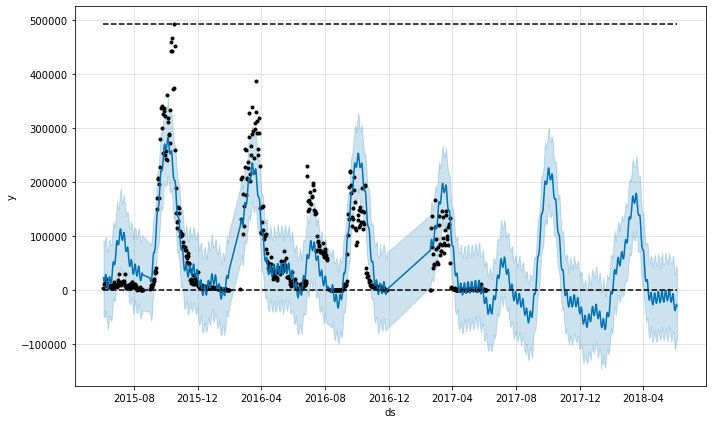

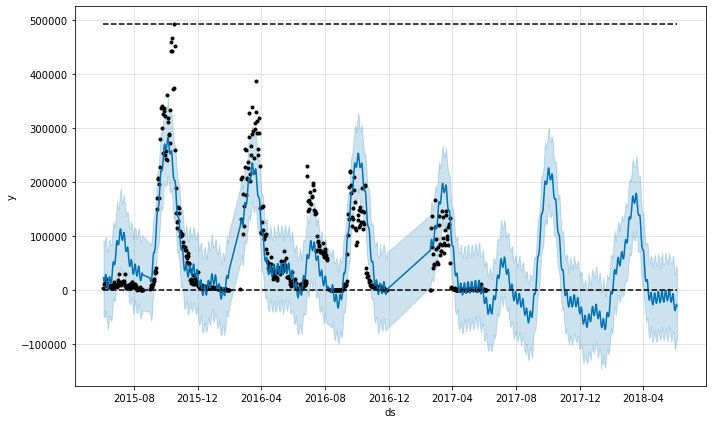

In [77]:
# Plot forecast
model.plot(forecast)

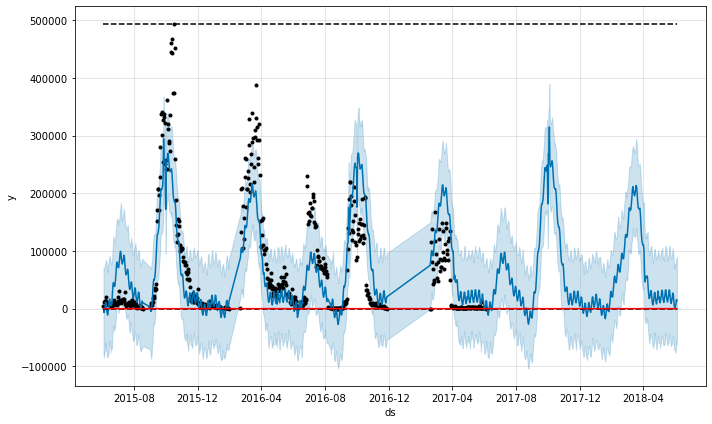

In [97]:
# Changing trend points
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

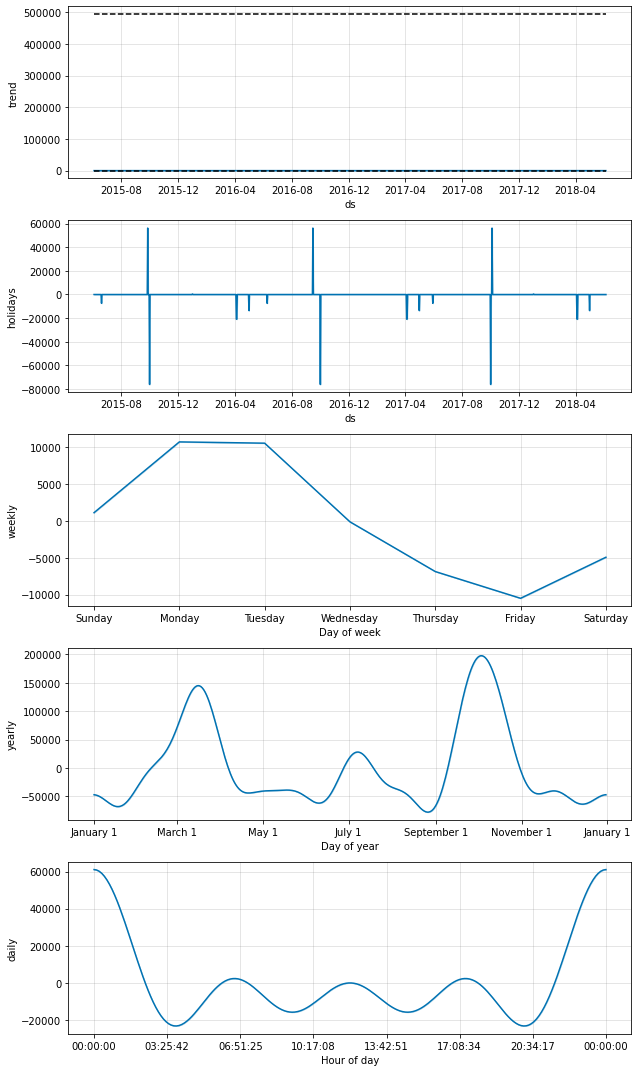

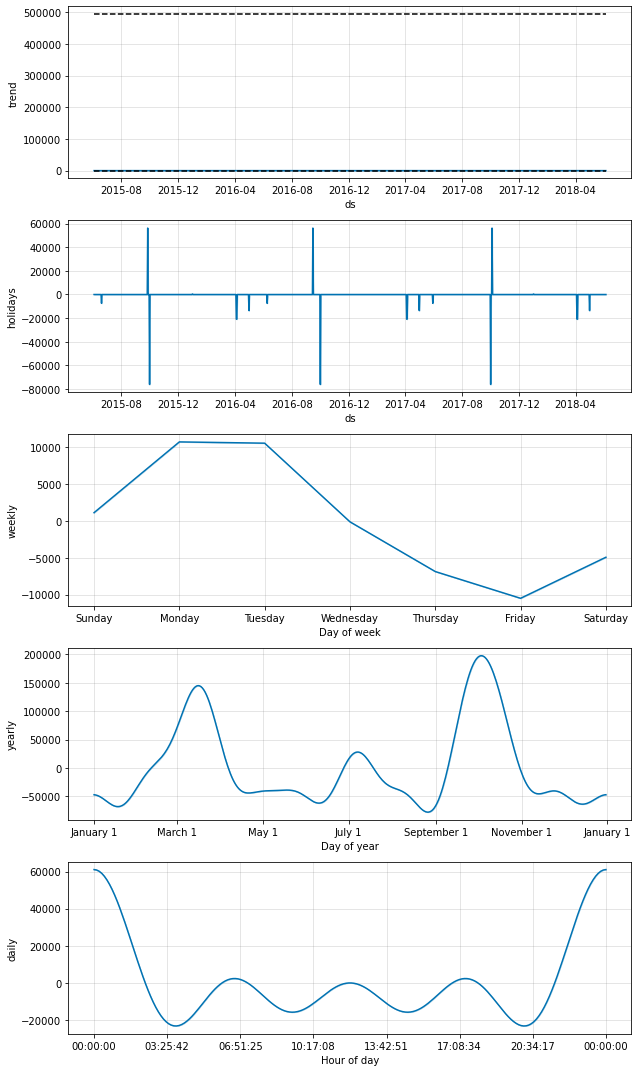

In [98]:
# Plot decomposition
model.plot_components(forecast)

#### Remove 2017 from data

In [99]:
new_final = final.iloc[:505]
# create Prophet model with American and Chinese holidays
new_model = Prophet(growth = 'logistic', yearly_seasonality=True, daily_seasonality=True)
#new_model.add_country_holidays(country_name='US')
new_model.add_country_holidays(country_name='China')

# fit the model
new_model.fit(new_final)

# perform forecast
new_future = new_model.make_future_dataframe(periods=365)
# set cap
new_future['cap'] = new_final['y'].max()
new_future['floor'] = 0
new_forecast = new_model.predict(new_future)

# Display forecast
display(new_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

,ds,yhat,yhat_lower,yhat_upper
0,2015-06-04,2769.679825,-67186.502750,78827.864162
1,2015-06-05,-3771.108222,-73447.723730,65969.590821
2,2015-06-06,1454.134455,-75866.034657,69199.456750
3,2015-06-07,5070.448612,-68207.027672,73677.519767
4,2015-06-08,10256.427779,-55212.609745,76869.774542
...,...,...,...,...
865,2017-11-23,13941.432749,-57256.800825,84231.570854
866,2017-11-24,9851.108000,-57944.038974,77734.256257
867,2017-11-25,17076.856373,-52990.315384,88370.380477
868,2017-11-26,22176.001783,-51889.747758,92822.992477


In [100]:
new_final

,ds,y,cap,floor
0,2015-06-04,5275.0,493881.0,0
1,2015-06-05,11399.0,493881.0,0
2,2015-06-06,13734.0,493881.0,0
3,2015-06-07,13044.0,493881.0,0
4,2015-06-08,12876.0,493881.0,0
...,...,...,...,...
500,2016-11-23,1773.0,493881.0,0
501,2016-11-24,620.0,493881.0,0
502,2016-11-25,984.0,493881.0,0
503,2016-11-26,630.0,493881.0,0


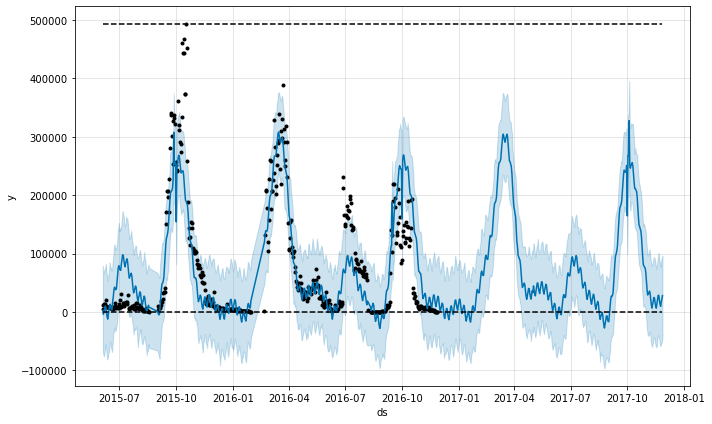

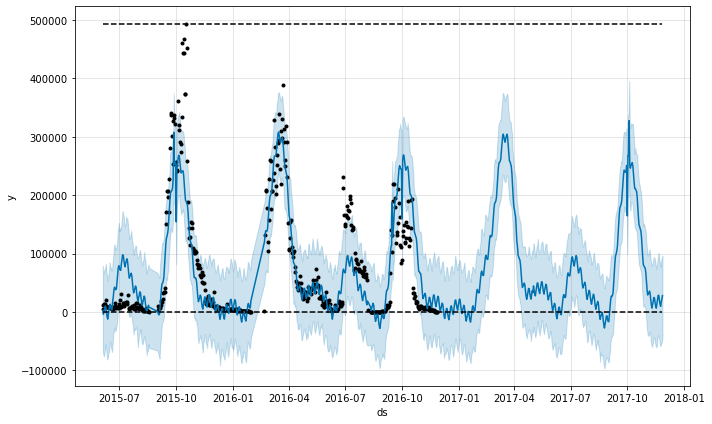

In [101]:
# Plot forecast
new_model.plot(new_forecast)

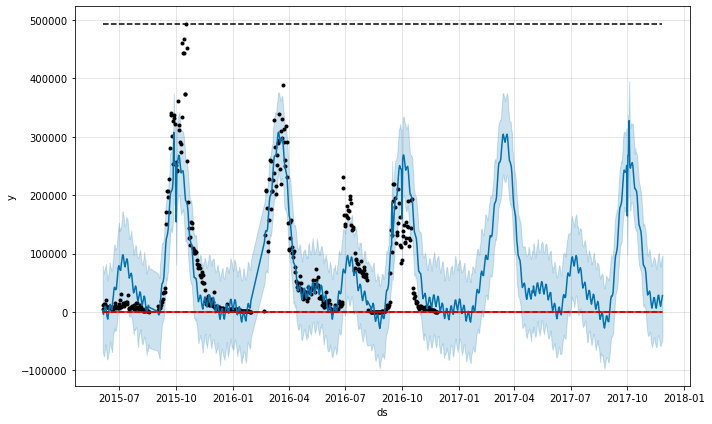

In [102]:
# Changing trend points
new_fig = new_model.plot(new_forecast)
new_a = add_changepoints_to_plot(new_fig.gca(), new_model, new_forecast)

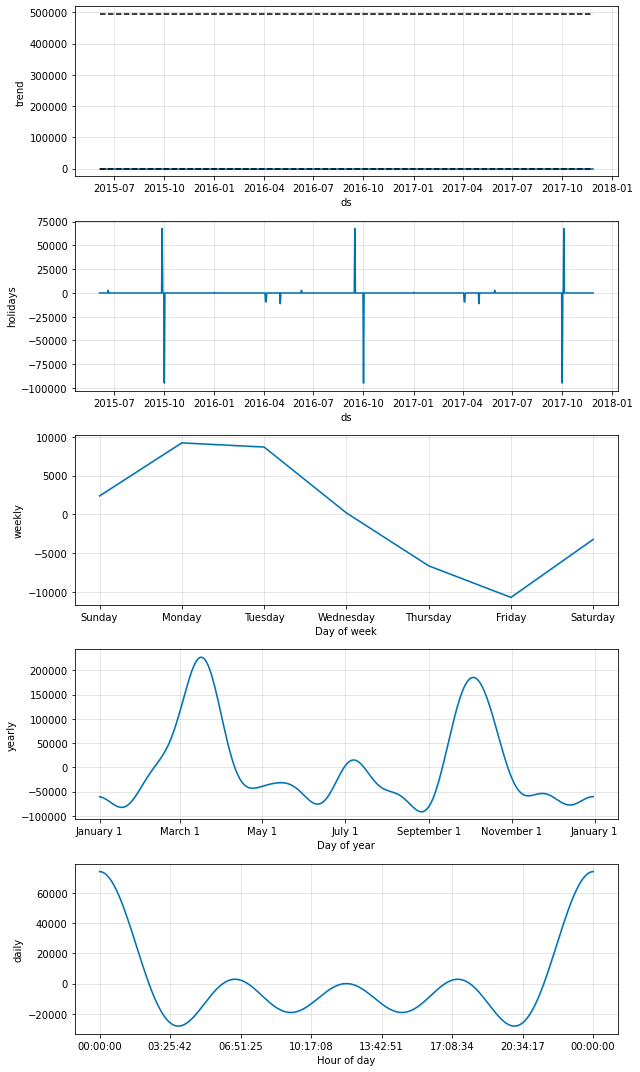

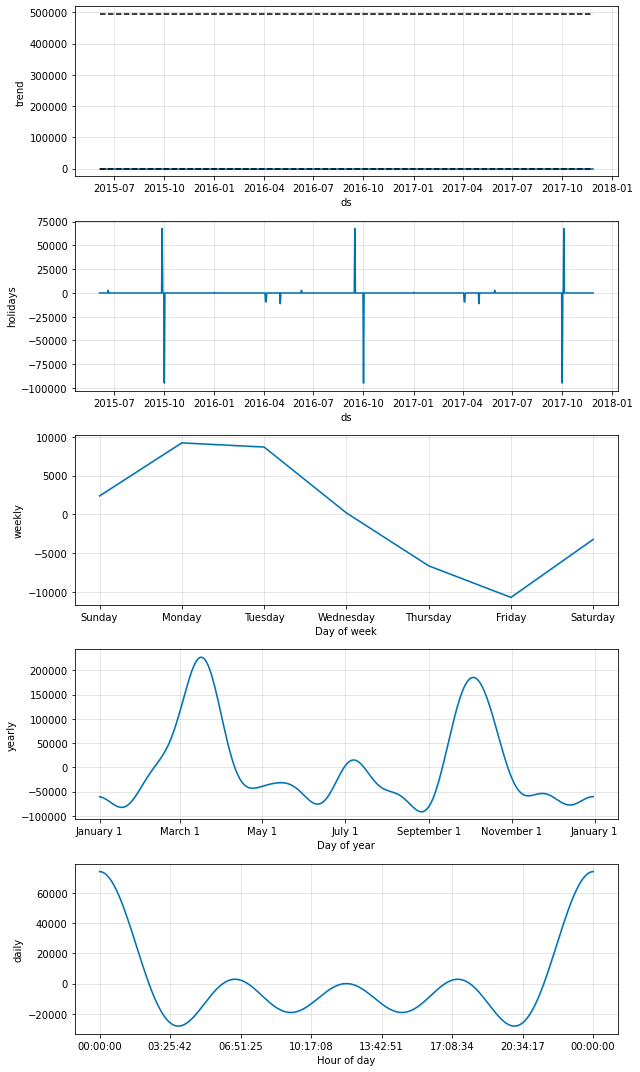

In [104]:
# Plot decomposition
new_model.plot_components(new_forecast)

### Train vs. Test

In [105]:
train = final.iloc[:333] # from June 4 2015 till June 4 2016
test = final.iloc[333:613] # from June 5 2016 till June 5 2017

In [107]:
# Provide cap and floor
train['cap'] = train['y'].max()
train['floor'] = 0
# create Prophet model with American and Chinese holidays
m = Prophet(growth = 'logistic', yearly_seasonality=True, daily_seasonality=True)
#model.add_country_holidays(country_name='US')
m.add_country_holidays(country_name='China')

# fit the model
m.fit(train)

# perform forecast
fut = model.make_future_dataframe(periods=len(test))
# set cap
fut['cap'] = final['y'].max()
fut['floor'] = 0
f = model.predict(fut)

# Display forecast
display(f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

C:\Users\Chris\AppData\Local\Temp/ipykernel_10380/2917903415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cap'] = train['y'].max()
C:\Users\Chris\AppData\Local\Temp/ipykernel_10380/2917903415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['floor'] = 0


,ds,yhat,yhat_lower,yhat_upper
0,2015-06-04,-1493.607010,-78095.651838,68367.321662
1,2015-06-05,-6714.305867,-81979.437900,69093.269715
2,2015-06-06,-2594.743224,-74808.245687,75685.557200
3,2015-06-07,2199.176730,-74051.965416,75344.747501
4,2015-06-08,10795.147398,-63989.028340,90345.065197
...,...,...,...,...
888,2018-03-08,170190.121457,98825.047895,241754.736020
889,2018-03-09,172467.869195,98331.831533,239592.839182
890,2018-03-10,183464.834562,111439.432753,256285.849740
891,2018-03-11,194367.600742,121245.001568,272706.531559


0.06547677420881742


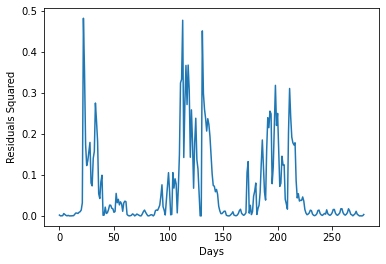

In [108]:
#print MAE 2
from sklearn.metrics import mean_squared_error

y_true = test['y'].values
endpoint = len(train)+len(test)
y_pred = f['yhat'][len(train):endpoint].values

#compute min-max scaled residuals
y_max = np.max(y_true)
y_min = np.min(y_true)

residuals_sq = np.square((y_true - y_pred)/(y_max - y_min))

#Plot residuals squared
plt.plot(residuals_sq)
plt.xlabel("Days")
plt.ylabel("Residuals Squared")

#Compute overall measure
mse = mean_squared_error(y_true, y_pred)
mse_minmax = mse /((y_max - y_min)**2)
print(mse_minmax)

In [109]:
# Print MAE

mae = mean_absolute_error(y_true, y_pred)
print('Trained from June 4 2015 till June 4 2016')
print('Tested from June 5 2016 till June 5 2017')
print('MAE =', round(mae, 3))

Trained from June 4 2015 till June 4 2016
Tested from June 5 2016 till June 5 2017
MAE = 44282.111


<AxesSubplot:xlabel='ds'>

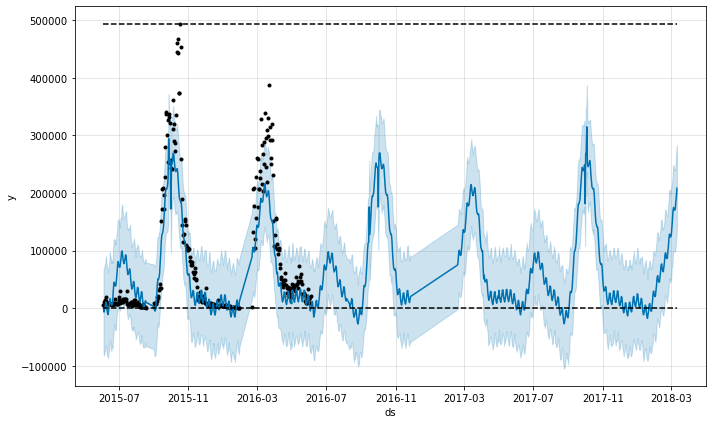

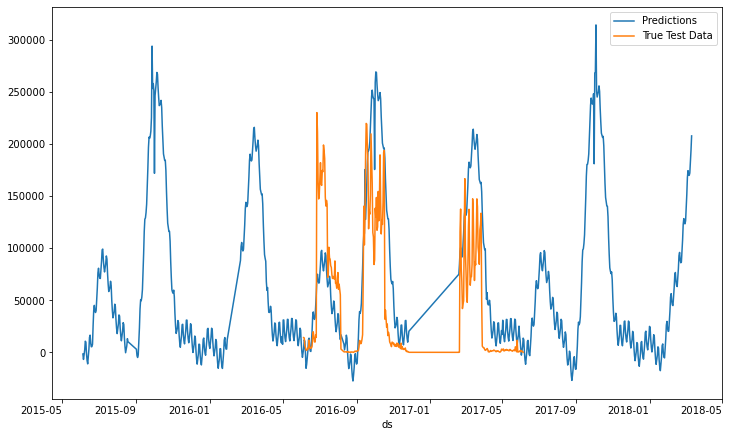

In [110]:
# Plot forecast
m.plot(f)
ax=f.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(12,8))
test.plot(x='ds', y='y',legend=True, label='True Test Data', ax=ax)

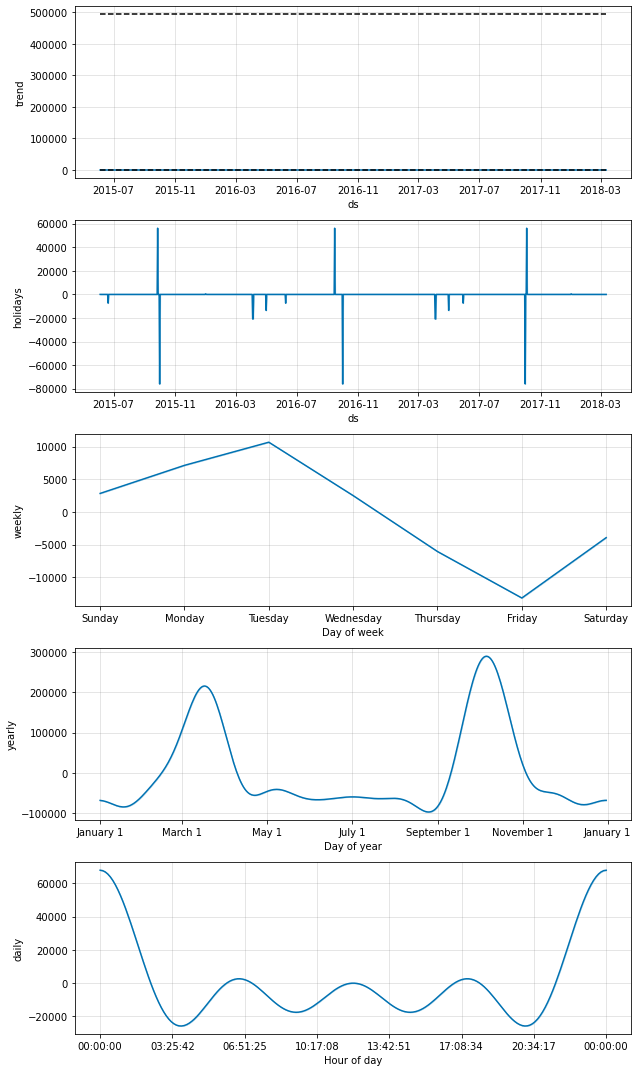

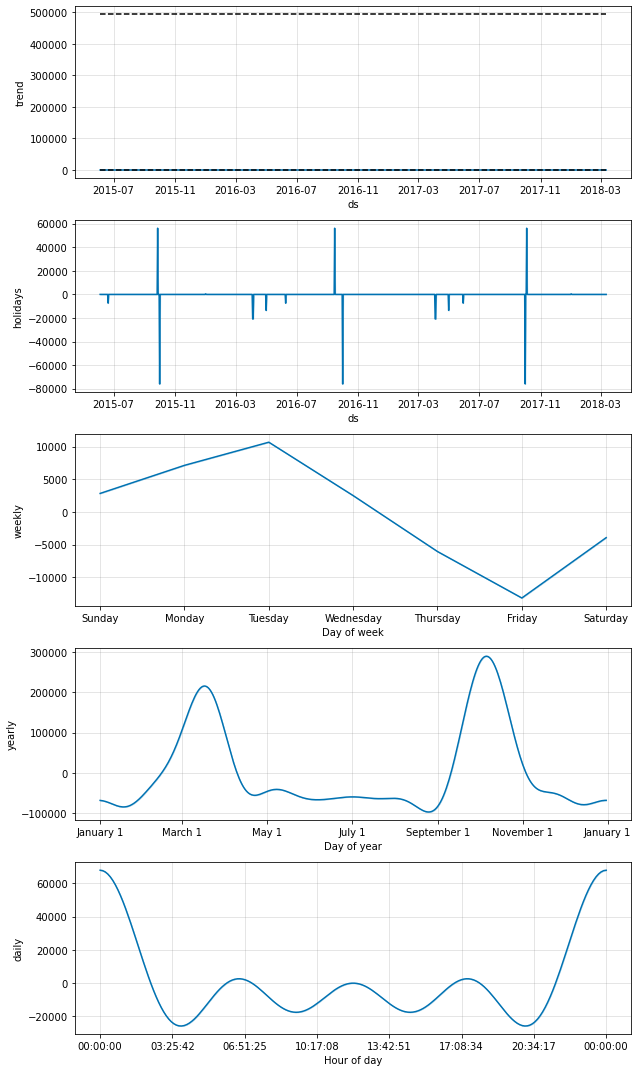

In [111]:
# Plot decomposition
m.plot_components(f)

#### Performance metrics

In [112]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [113]:
# Initial training period.
initial = len(train)
initial = str(initial) + ' days'

# Period length that we perform the cross validation for.
period = len(train)
period = str(period) + ' days'

# Horizon of prediction essentially for each fold.
horizon = len(test)
horizon = str(horizon) + ' days'

fb_cv = cross_validation(model, initial=initial, horizon=horizon)

# Performance Metrics of fb_cv
performance_metrics(fb_cv)

INFO:prophet:Making 1 forecasts with cutoffs between 2016-08-29 00:00:00 and 2016-08-29 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,19 days,1.232210e+09,35102.850297,29311.484670,3.230005,3.084159,1.110351,0.894737
1,20 days,1.266404e+09,35586.565937,30586.803811,3.180689,3.084159,1.011590,0.894737
2,21 days,1.286576e+09,35868.876768,31404.284699,2.858690,2.553130,0.911470,0.894737
3,22 days,1.430393e+09,37820.537399,33719.535543,2.487296,0.850884,0.819714,0.842105
4,23 days,2.215240e+09,47066.336417,39583.689196,2.163878,0.850884,0.750268,0.789474
...,...,...,...,...,...,...,...,...
175,276 days,1.193754e+09,34550.740884,32463.892633,24.654196,25.023225,1.724158,1.000000
176,277 days,1.100978e+09,33180.995815,30271.184252,23.924151,25.023225,1.650760,1.000000
177,278 days,9.742512e+08,31212.997130,27890.504528,22.812549,25.023225,1.618480,1.000000
178,279 days,8.404699e+08,28990.858424,25641.404346,22.044731,18.756056,1.610202,1.000000


C:\Users\Chris\anaconda3\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Chris\anaconda3\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


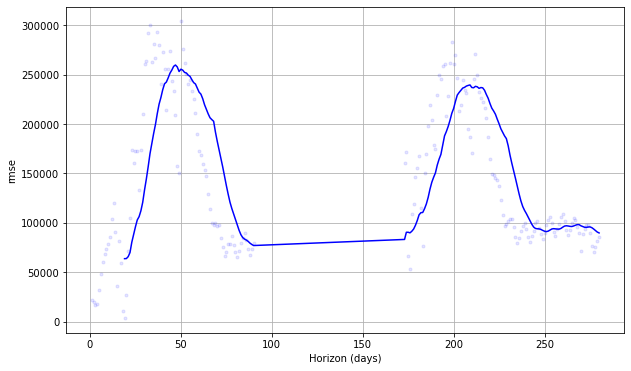

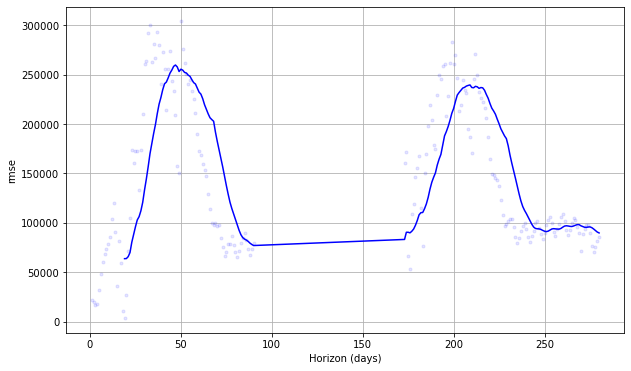

In [94]:
plot_cross_validation_metric(fb_cv,'rmse')

C:\Users\Chris\anaconda3\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Chris\anaconda3\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


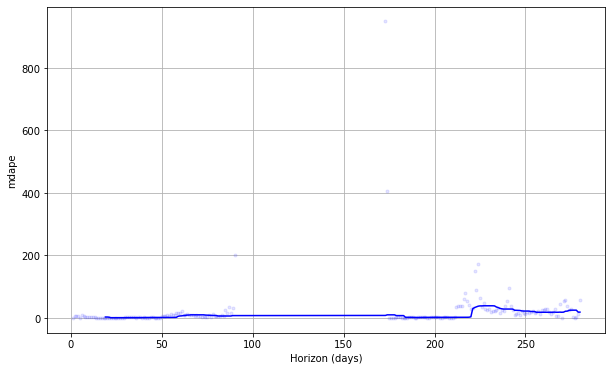

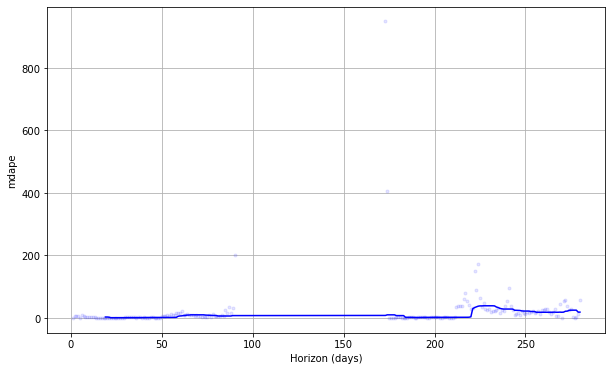

In [114]:
plot_cross_validation_metric(fb_cv,'mdape')